7장 물류 네트워크 최적 설계를 위한 테크닉 

테크닉 61. 운송 최적화 문제를 풀어보자. 

In [1]:
# 최적화 계산 라이브러리(pulp, ortoolpy)를 사용해 운송 최적화 문제를 풀어보자 

# !pip install pulp
!pip install ortoolpy

In [2]:
import numpy as np 
import pandas as pd
from itertools import product 
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, addvars, addvals

In [3]:
# 데이터 불러오기 
df_tc = pd.read_csv('trans_cost.csv', index_col="공장")
df_demand = pd.read_csv('demand.csv') 
df_supply = pd.read_csv('supply.csv')

In [4]:
# 예측 가능한 난수 

np.random.seed(1) # 얘가 없으면 말 그대로 난수 발생. 하지만 얘가 있으므로 동일값 발생
np.random.randint(99,size=5) 

array([37, 12, 72,  9, 75])

In [5]:
# 초기 설정 # 
np.random.seed(1) # 같은 형태의 난수 발생 
nw = len(df_tc.index)
nf = len(df_tc.columns)
pr = list(product(range(nw), range(nf)))

In [6]:
# 수리 모델 작성 # 
m1 = model_min() # 최소화 실행 모델 

# m1 lpSum 함수를 이용해 정의 
# df_tc는 운송정보 
v1 = {(i, j):LpVariable('v%d_%d'%(i,j), lowBound=0) for i,j in pr} 
m1 += lpSum(df_tc.iloc[i][j] * v1[i,j] for i,j in pr)

# 제약 조건 정의 
for i in range(nw): # 수요량을 만족 시키는 제약조건 
    m1 += lpSum(v1[i,j] for j in range(nf)) <= df_supply.iloc[0][i]
for j in range(nf): # 공급 한계를 넘지 않는 제약조건 
    m1 += lpSum(v1[i,j] for i in range(nw)) >= df_demand.iloc[0][j]
m1.solve() # 최적화문제를 solve()로 해결. 변수 v1의 최적의 운송 비용을 구한다. 

# 총 운송비용은 1296만이며, 앞에서 구한 1433만원보다 현저히 낮은 비용을 얻을 수 있다.

1

In [7]:
# 총 운송 비용 계산 # 
df_tr_sol = df_tc.copy()
total_cost = 0
for k, x in v1.items():
    i, j = k[0], k[1]
    df_tr_sol.iloc[i][j] = value(x)
    total_cost += df_tc.iloc[i][j] * value(x)
    
print(df_tr_sol)
print("총 운송 비용: " + str(total_cost))

    F1  F2  F3  F4
공장                
W1  28   7   0   0
W2   0   0  31   5
W3   0  22   0  20
총 운송 비용: 1296.0


테크닉 62. 최적 운송 경로를 네트워크로 확인하자.

In [8]:
# 최적 운송 경로를 네트워크 가시화로 확인하기 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import networkx as nx 

In [9]:
# 데이터 불러오기 
df_tr = pd.read_csv('trans_route.csv', index_col="공장")
df_pos = pd.read_csv('trans_route_pos.csv')

In [10]:
# 객체 생성 
G = nx.Graph()

In [11]:
# 노드 생성 
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])

In [12]:
# 엣지 설정 및 옛지의 가중치 리스트화      # 결과값 다름 수정 필요 
num_pre = 0 
edge_weights = [] 
size = 0.1
for i in range(len(df_pos.columns)):
    for j in range(len(df_pos.columns)):
        if not (i == j):
            # 엣지 추가 
            G.add_edge(df_pos.columns[i], df_pos.columns[j])
            # 엣지 가중치 추가 
            if num_pre < len(G.edges):
                num_pre = len(G.edges)
                weight = 0
                if (df_pos.columns[i] in df_tr.columns) and (df_pos.columns[j] in df_tr.index):
                    if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
                        weight = df_tr[df_pos.columns[i]][df_pos.columns[j]] * size
                elif (df_pos.columns[j] in df_tr.columns) and (df_pos.columns[i] in df_tr.index):
                    if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
                        weight = df_tr[df_pos.columns[j]][df_pos.columns[i]] * size 
                edge_weights.append(weight)

In [13]:
# 좌표 설정 
pos = {} 
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0], df_pos[node][1])

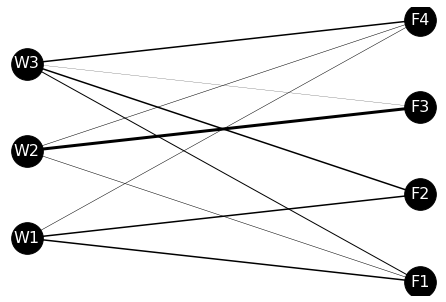

In [14]:
# 그리기 
nx.draw(G, pos, with_labels=True, font_size=16, node_size=1000, node_color='k', font_color='w', width=edge_weights)

# 표시 
plt.show()

테크닉 63. 최적 운송 경로가 제약 조건을 만족시키는지 확인하자 

In [15]:
# 테크닉 60에서 작성한 제약조건을 계산하는 함수를 이용해 
# 계산된 운송 경로가 제약 조건을 만족하는지 확인해보자. 

import pandas as pd
import numpy as np 

# 데이터 불러오기 
df_demand = pd.read_csv("demand.csv")
df_supply = pd.read_csv("supply.csv")

In [16]:
# 제약 조건 계산 함수 
# 수요측 
def condition_demand(df_tr, df_demand):
    flag = np.zeros(len(df_demand.columns))
    for i in range(len(df_demand.columns)):
        temp_sum = sum(df_tr[df_demand.columns[i]])
        if (temp_sum >= df_demand.iloc[0][i]):
            flag[i] = 1
    return flag 

# 공급측 
def condition_supply(df_tr, df_supply):
    flag = np.zeros(len(df_supply.columns))
    for i in range(len(df_supply.columns)):
        temp_sum = sum(df_tr.loc[df_supply.columns[i]])
        if temp_sum <= df_supply.iloc[0][i]:
            flag[i] = 1
    return flag 

print("수요조건 계산결과: " + str(condition_demand(df_tr_sol, df_demand)))
print("공급조건 계산결과: " + str(condition_supply(df_tr_sol, df_supply)))

수요조건 계산결과: [1. 1. 1. 1.]
공급조건 계산결과: [1. 1. 1.]


테크닉 64. 생산 계획 데이터를 불러오자

In [17]:
# 어떤 제품을 얼마나 만들 것인지 계획을 세워보자. 

import pandas as pd 

# 데이터 불러오기 
df_material = pd.read_csv('product_plan_material.csv', index_col='제품')
df_profit = pd.read_csv('product_plan_profit.csv', index_col='제품')
df_stock = pd.read_csv('product_plan_stock.csv', index_col='항목')
df_plan = pd.read_csv('product_plan.csv', index_col='제품')

In [18]:
print(df_material) # 2개의 제품에 필요한 3가지 원료 
print(df_profit) # 각 제품의 이익(판매 - 원가) 
print(df_stock) # 각 원료의 재고 
print(df_plan) # 제품의 생산량 

     원료1  원료2  원료3
제품                
제품1    1    4    3
제품2    2    4    1
      이익
제품      
제품1  5.0
제품2  4.0
    원료1  원료2  원료3
항목               
재고   40   80   50
      생산량
제품       
제품1    16
제품2     0


테크닉 65. 이익을 계산하는 함수를 만들자.

In [19]:
# 생산계획 최적화는 최적화 문제와 흐름이 동일하다. 
# 먼저 목적함수와 제약조건을 정의하고, 제약조건 아래서 목적함수를 최소화(또는 최대화)하는 변수의 조합을 찾는다. 
# 이를 이용해 이익을 계산할 함수를 만들고 그것을 목적함수로 최대화한다. 

In [20]:
def product_plan(df_profit, df_plan):
    profit = 0
    for i in range(len(df_profit.index)):
        for j in range(len(df_plan.columns)):
            profit += df_profit.iloc[i][j] * df_plan.iloc[i][j]
            # print(profit)
        return profit

print("총 이익: " + str(product_plan(df_profit, df_plan)))

# 총 이익은 각 제품의 이익과 제조량의 곱의 합 
# 따라서 총 이익은 제품 2가 없으므로 80만원... 
# 제품 2를 늘리면 어느 정도 이익이 증가하게 될지 계산해보자.  

총 이익: 80.0


테크닉 66. 생산 최적화 문제를 풀어보자

In [21]:
# 정식화한 목적함수인 이익함수의 최대화를 목적으로 최적화 계산을 진행 
# 문제를 푸는 흐름은 테크닉 61과 동일 

import pandas as pd
from pulp import LpVariable, lpSum, value
from ortoolpy import model_max, addvars, addvals

In [22]:
df = df_material.copy()
inv = df_stock

m = model_max() # 최대화 계산 변수 선언 

v1 = {(i):LpVariable('v%d'%(i), lowBound = 0) for i in range(len(df_profit))}
# v1을 제품수와 같은 차원으로 정의 
# v1과 제품별 이익의 곱의 합으로 목적함수 정의 

m += lpSum(df_profit.iloc[i] * v1[i] for i in range(len(df_profit)))

for i in range(len(df_material.columns)):
    m += lpSum(df_material.iloc[j, i] * v1[j] for j in range(len(df_profit))) <= df_stock.iloc[:,i]
    # print(m)
    m.solve()
# 제약 조건: 각 원료의 사용량이 재고를 넘지 않게 조건 정의 

df_plan_sol = df_plan.copy()
for k, x in v1.items():
    df_plan_sol.iloc[k] = value(x)
print(df_plan_sol)
print("총 이익: " + str(value(m.objective)))

      생산량
제품       
제품1    15
제품2     5
총 이익: 95.0


테크닉 67. 최적 생산 계획이 제약 조건을 만족하는지 확인하자. 

In [25]:
def condition_stock(df_plan,df_material, df_stock):
    flag = np.zeros(len(df_material.columns))
    for i in range(len(df_material.columns)):
        temp_sum = 0
        for j in range(len(df_material.index)):
            temp_sum = temp_sum + df_material.iloc[j][i] * float(df_plan.iloc[j])
        if (temp_sum <= float(df_stock.iloc[0][i])):
            flag[i] = 1
        print(df_material.columns[i] + " 사용량: " + str(temp_sum) + ", 재고: " + str(float(df_stock.iloc[0][i])))
    return flag
print("제약 조건 계산 결과: " + str(condition_stock(df_plan_sol, df_material, df_stock)))

원료1 사용량: 25.0, 재고: 40.0
원료2 사용량: 80.0, 재고: 80.0
원료3 사용량: 50.0, 재고: 50.0
제약 조건 계산 결과: [1. 1. 1.]


테크닉 68. 물류 네트워크 설계 문제를 풀어보자. 

In [26]:
# 실제 물류 네트워크는 운송 경로와 생산 계획 최적화 문제를 동시에 고려해야 한다. 
# 운송 비용과 제조 비용이 수요를 만독하면서 최소가 되게 정식화. 
# 목적함수: 운송 비용과 제조 비용의 합 
# 제약조건: 각 대리점의 판매 수가 수요 수를 넘는 것 
# ortoolpy 라이브러리의 logistics_network 이용 (많이 쓰이지 않음....)

In [47]:
import numpy as np 
import pandas as pd 

제품 = list('AB')
대리점 = list('PQ')
공장 = list('XY')
레인 = (2, 2)

# 운송비 
tbdi = pd.DataFrame(((j, k) for j in 수요지 for k in 공장), columns = ['대리점', '공장'])
tbdi['운송비'] = [1,2,3,1]
print(tbdi)

# 수요 
tbde = pd.DataFrame(((j, i) for j in 수요지 for i in 제품), columns = ['대리점', '제품'])
tbde['수요'] = [10,10,20,20]
print(tbde)

# 생산 
tbfa = pd.DataFrame(((k, l, i, 0, np.inf) for k, nl in zip (공장, 레인) for l in range(nl) for i in 제품), columns = ['공장', '레인', '제품', '하한', '상한'])
tbfa['생산비'] = [1,np.nan,np.nan, 1,3,np.nan,5,3]
tbfa.dropna(inplace=True)
tbfa.loc[4,'상한'] = 10
print(tbfa)

  대리점 공장  운송비
0   P  X    1
1   P  Y    2
2   Q  X    3
3   Q  Y    1
  대리점 제품  수요
0   P  A  10
1   P  B  10
2   Q  A  20
3   Q  B  20
  공장  레인 제품  하한    상한  생산비
0  X   0  A   0   inf  1.0
3  X   1  B   0   inf  1.0
4  Y   0  A   0  10.0  3.0
6  Y   1  A   0   inf  5.0
7  Y   1  B   0   inf  3.0


In [44]:
from ortoolpy import logistics_network
_, tbdi2,_ = logistics_network(tbde, tbdi, tbfa,dep = "대리점", dem="수요",
                              fac = "공장", prd = '제품', tcs = "운송비", 
                               pcs = "생산비",lwb='하한',upb='상한')

print(tbfa)
print(tbdi2)


# VarY - 최적 생산량 저장, ValX = 최적 운송량 저장 

  공장  레인 제품  하한    상한  생산비     VarY  ValY
0  X   0  A   0   inf  1.0  v000061  20.0
3  X   1  B   0   inf  1.0  v000062  10.0
4  Y   0  A   0  10.0  3.0  v000063  10.0
6  Y   1  A   0   inf  5.0  v000064   0.0
7  Y   1  B   0   inf  3.0  v000065  20.0
  대리점 공장  운송비 제품     VarX  ValX
0   P  X    1  A  v000053  10.0
1   P  X    1  B  v000054  10.0
2   Q  X    3  A  v000055  10.0
3   Q  X    3  B  v000056   0.0
4   P  Y    2  A  v000057   0.0
5   P  Y    2  B  v000058   0.0
6   Q  Y    1  A  v000059  10.0
7   Q  Y    1  B  v000060  20.0


테크닉 69. 최적 네트워크의 운송 비용과 그 내역을 계산하자 

In [45]:
# 위 테크닉 68에서 뽑아낸 정보가 타당한지 확인하기 
# 운송비용 = '운송비' 칼럼 * ValX(운송량) 

tbdi2 = tbdi2[['공장','대리점','운송비','제품','VarX','ValX']]
tbdi2

,공장,대리점,운송비,제품,VarX,ValX
0,X,P,1,A,v000053,10.0
1,X,P,1,B,v000054,10.0
2,X,Q,3,A,v000055,10.0
3,X,Q,3,B,v000056,0.0
4,Y,P,2,A,v000057,0.0
5,Y,P,2,B,v000058,0.0
6,Y,Q,1,A,v000059,10.0
7,Y,Q,1,B,v000060,20.0


In [48]:
trans_cost = 0
for i in range(len(tbdi2.index)):
    trans_cost += tbdi2["운송비"].iloc[i] * tbdi2["ValX"].iloc[i]
print("총 운송비: " + str(trans_cost))

총 운송비: 80.0


테크닉 70. 최적 네트워크의 생산 비용과 그 내역을 계산하자

In [50]:
# 생산비용 = '샌산비' 칼럼 * ValY(최적 생산량)

product_cost = 0
for i in range(len(tbfa.index)) :
    product_cost += tbfa["생산비"].iloc[i]*tbfa["ValY"].iloc[i]
    
print("총 생산비:"+str(product_cost))

KeyError: 'ValY'